Se importan las librerías para obtener información de BigQuery

In [1]:
from google.cloud import bigquery
import seaborn as sns
import pandas

# objeto Client
client = bigquery.Client()

# Referencia al Dataset chicago_crime
dataset_ref = client.dataset("chicago_crime", project="bigquery-public-data")

# API request - traer el dataset
dataset = client.get_dataset(dataset_ref)

Using Kaggle's public dataset BigQuery integration.


Listamos las tablas en el dataset

In [2]:
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

crime


Listamos las columnas en la tabla Crime

In [3]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("crime")

# API request - fetch the table
table = client.get_table(table_ref)
table.schema

[SchemaField('unique_key', 'INTEGER', 'REQUIRED', None, (), None),
 SchemaField('case_number', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('block', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('iucr', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('primary_type', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('description', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('location_description', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('arrest', 'BOOLEAN', 'NULLABLE', None, (), None),
 SchemaField('domestic', 'BOOLEAN', 'NULLABLE', None, (), None),
 SchemaField('beat', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('district', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('ward', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_area', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('fbi_code', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('x_coord

In [4]:
client.list_rows(table, max_results=5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  """Entry point for launching an IPython kernel.


,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,3205,HL435664,2005-06-21 09:28:00+00:00,103XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,9,49,01A,1179414.0,1836239.0,2005,2022-09-18 04:45:51+00:00,41.705921,-87.618608,"(41.705920727, -87.618607847)"
1,24322,JB536039,2018-12-01 02:39:00+00:00,000XX W 103RD ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,34,49,01A,1177846.0,1836675.0,2018,2022-08-31 04:51:30+00:00,41.707153,-87.624337,"(41.70715274, -87.624336573)"
2,20708,HV572023,2012-11-21 08:30:00+00:00,103XX S FOREST AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,True,...,9,49,01A,1180074.0,1836444.0,2012,2022-09-18 04:45:51+00:00,41.706468,-87.616185,"(41.706468217, -87.616184739)"
3,2446,HJ698541,2003-10-17 01:36:00+00:00,104XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,...,9,49,01A,1179434.0,1835549.0,2003,2022-08-31 04:51:30+00:00,41.704027,-87.618556,"(41.704026818, -87.618555581)"
4,25831,JE181828,2021-03-28 12:11:00+00:00,007XX E 103RD ST,0110,HOMICIDE,FIRST DEGREE MURDER,GAS STATION,True,False,...,9,50,01A,1182951.0,1836828.0,2021,2022-08-31 04:51:30+00:00,41.707456,-87.605637,"(41.707455731, -87.605637491)"


Podemos acceder a distintas columnas por número de col

In [5]:
client.list_rows(table, selected_fields=table.schema[19:22], max_results=5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  """Entry point for launching an IPython kernel.


,latitude,longitude,location
0,41.705921,-87.618608,"(41.705920727, -87.618607847)"
1,41.707153,-87.624337,"(41.70715274, -87.624336573)"
2,41.706468,-87.616185,"(41.706468217, -87.616184739)"
3,41.704027,-87.618556,"(41.704026818, -87.618555581)"
4,41.707456,-87.605637,"(41.707455731, -87.605637491)"


Creamos un query en SQL donde nos traemos los campos tipo primario, descripción, arresto y año. La transformamos en un dataframe, no sin antes realizar la validación de cuantos bytes se procesarán, esto nos ayuda a mantener un control sobre el límite que nos impone la plataforma Kaggle al momento de hacer querys.

In [6]:
query = """
        SELECT primary_type, description, arrest, year
        FROM `bigquery-public-data.chicago_crime.crime`
        """
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

# API request - dry run query to estimate costs
dry_run_query_job = client.query(query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))
query_job = client.query(query)
crimes = query_job.to_dataframe().head()
crimes.head()

This query will process 299510371 bytes.


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,primary_type,description,arrest,year
0,HOMICIDE,FIRST DEGREE MURDER,True,2012
1,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,False,2019
2,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,False,2012
3,ROBBERY,ARMED:KNIFE/CUTTING INSTRUMENT,False,2001
4,ROBBERY,ARMED: OTHER DANGEROUS WEAPON,False,2002


Con este dataframe podemos visualizar la información ya traida desde el servidor y realizar un procesamiento más profundo a los datos.

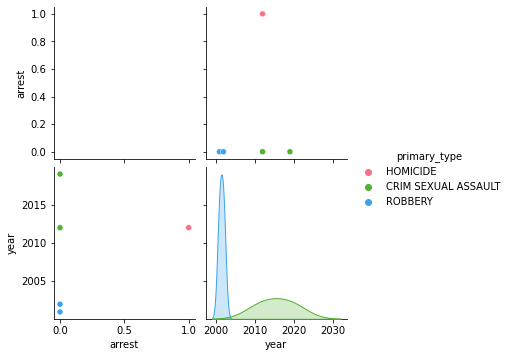

In [7]:
 g = sns.pairplot(crimes, hue="primary_type", palette="husl")


Hagamos un modelo predictivo con esta información obtenida. Para eso vamos a estimar cuantos crimenes se podrían cometer durante el año 2023

In [8]:
crimes = pandas.get_dummies(crimes)

y = crimes.arrest

crimes_features = ["primary_type_CRIM SEXUAL ASSAULT","primary_type_HOMICIDE","description_ARMED: OTHER DANGEROUS WEAPON", "description_ARMED:KNIFE/CUTTING INSTRUMENT","description_FIRST DEGREE MURDER","description_NON-AGGRAVATED"]
x = crimes[crimes_features]
#x.describe()
crimes.head()

,arrest,year,primary_type_CRIM SEXUAL ASSAULT,primary_type_HOMICIDE,primary_type_ROBBERY,description_ARMED: OTHER DANGEROUS WEAPON,description_ARMED:KNIFE/CUTTING INSTRUMENT,description_FIRST DEGREE MURDER,description_NON-AGGRAVATED
0,True,2012,0,1,0,0,0,1,0
1,False,2019,1,0,0,0,0,0,1
2,False,2012,1,0,0,0,0,0,1
3,False,2001,0,0,1,0,1,0,0
4,False,2002,0,0,1,1,0,0,0


In [9]:
from sklearn.tree import DecisionTreeRegressor
crimes_model = DecisionTreeRegressor(random_state=1)
crimes_model.fit(x, y)

DecisionTreeRegressor(random_state=1)

In [10]:
print("Predicciones para los siguientes 5 casos:")

print("Las predicciones son")
print(crimes_model.predict(x.head()))
x.head()

Predicciones para los siguientes 5 casos:
Las predicciones son
[1. 0. 0. 0. 0.]


,primary_type_CRIM SEXUAL ASSAULT,primary_type_HOMICIDE,description_ARMED: OTHER DANGEROUS WEAPON,description_ARMED:KNIFE/CUTTING INSTRUMENT,description_FIRST DEGREE MURDER,description_NON-AGGRAVATED
0,0,1,0,0,1,0
1,1,0,0,0,0,1
2,1,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,1,0,0,0


De los siguientes 5 casos, unicamente el primero será arrestado por homicidio en primer grado
El resto de los casos constan de 2 abusos sexuales no agravados
un ataque con arma blanca y un ataque con otro tipo de arma peligrosa que no resultan en arresto

Como no se tienen datos de nuevos casos para saber si terminan en arresto o no, usamos algunos datos del dataset que ya tenemos a modo demostrativo.